In [1]:
import sys
import os
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy as np
sys.path.append("../..")
from diachr import DiachromaticInteractionSet
from diachr import IaFreqDistAnalysis

# Types of mapped paired-end reads ans configurations of interactions

In paired-end sequencing, four different read pairs can be distinguished after mapping:

1. The reads are mapped onto different strands and point to each other (Type `0`)
2. The reads are mapped onto different strands and point away from each other (Type `1`)
3. The reads both are mapped to the forward strand (Type `2`)
4. The reads both are mapped to the reverse strand (Type `3`)

Type `0` read pairs typically occur in paired-end sequencing of fragmented DNA. Due to the re-ligation step, all four types (`0`, `1`, `2`, `3`) can occur  occur with Hi-C. In the first part of this notebook, we determine the frequencies of the four types.

We also distinguish ten configurations of interactions (`0X`, `1X`, `2X`, `3X`, `01`, `02`, `03`, `12`, `13`, `23`), depending on which of the four types of mapped paired-end reads predominate within individual interactions. In the first part of this notebook, we determine the frequencies of the different configurations of interactions.

## Loading interaction data

We analyzed a large dataset containing Hi-C (`HC`) and capture Hi-C data (`CHC`). There are Hi-C datasets for eight different celltypes:
```
MK, ERY, NEU, MON, MAC_M0, NB, NCD4, NCD8
```
We also created a dataset by pooling the Hi-C datasets for all eight cell types. To load this dataset, set `PROTOCOL=HC_POOLED`.

Furthermore, there are capture Hi-C datasets for 17 celltypes:
```
MK, ERY, NEU, MON, MAC_M0, MAC_M1, MAC_M2, EP, NB, TB, FOET, NCD4, TCD4, NACD4, ACD4, NCD8, TCD8
```

For the Hi-C datasets of individual celltypes, there is data for the minimum interaction distances `5,000`,`10,000` and `20,000`. For the pooled Hi-C and capture Hi-C datasets, there is only data for a minimum interaction distance of `20,000`.

The code in the following cell can be used to load an interaction set for a specific protocol, cell type and interaction distance.

In [2]:
PROTOCOL = 'CHC'
CELL_TYPE_SHORT = 'MAC_M0'
MIN_I_DIST = '20000'
if PROTOCOL == 'CHC':
    MIN_I_DIST = '20000'
RPC_RULE = 'ht'
FDR = '05'
if PROTOCOL == 'CHC':
    INTERACTION_FILE = '../../DICer_interactions/' + RPC_RULE.upper() + '/FDR0' + FDR + '/CHC/JAV_' + CELL_TYPE_SHORT + '_RALT_20000_' + RPC_RULE + '_fdr0.' + FDR + '_evaluated_and_categorized_interactions.tsv.gz'
    OUT_PREFIX = 'JAV_' + CELL_TYPE_SHORT + '_CHC_RALT_' + MIN_I_DIST + '_' + RPC_RULE.lower()
if PROTOCOL == 'HC_POOLED':
    INTERACTION_FILE = '../../DICer_interactions/HT/FDR005/HC/20000/JAV_ALL_HC_RALL_ALT_20000_ht_fdr0.05_evaluated_and_categorized_interactions.tsv.gz'
    OUT_PREFIX = 'JAV_' + 'POOLED_HC_FDR005' + '_HC_RALT_20000_' + RPC_RULE.lower()
if PROTOCOL == 'HC':
    INTERACTION_FILE = '../../DICer_interactions/' + RPC_RULE.upper() + '/FDR0' + FDR + '/HC/' + MIN_I_DIST + '/JAV_' + CELL_TYPE_SHORT + '_HC_RALT_' + MIN_I_DIST + '_' + RPC_RULE + '_fdr0.' + FDR + '_evaluated_and_categorized_interactions.tsv.gz'
    OUT_PREFIX = 'JAV_' + CELL_TYPE_SHORT + '_HC_RALT_'  + MIN_I_DIST + '_' + RPC_RULE.lower()

# Create DiachromaticInteractionSet
d11_interaction_set = DiachromaticInteractionSet(rpc_rule = RPC_RULE)
d11_interaction_set.parse_file(
    i_file = INTERACTION_FILE,
    verbose = True)

# Pass the DiachromaticInteractionSet to IaFreqDistAnalysis
ia_freq_dist_analysis = IaFreqDistAnalysis()
report_dict = ia_freq_dist_analysis.ingest_interaction_set(
    d11_inter_set = d11_interaction_set,
    verbose = True)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../../DICer_interactions/HT/FDR005/CHC/JAV_MAC_M0_RALT_20000_ht_fdr0.05_evaluated_and_categorized_interactions.tsv.gz
	[INFO] Parsed 1,000,000 interaction lines ...
	[INFO] Parsed 2,000,000 interaction lines ...
	[INFO] Parsed 3,000,000 interaction lines ...
	[INFO] Parsed 4,000,000 interaction lines ...
	[INFO] Parsed 5,000,000 interaction lines ...
	[INFO] Parsed 6,000,000 interaction lines ...
	[INFO] Parsed 7,000,000 interaction lines ...
	[INFO] Parsed 8,000,000 interaction lines ...
	[INFO] Parsed 9,000,000 interaction lines ...
	[INFO] Set size: 9,648,210
[INFO] ... done.
[INFO] Reading interactions and group them according to chromosomes, interaction and enrichment category ...
	[INFO] Read 1,000,000 interactions ...
	[INFO] Read 2,000,000 interactions ...
	[INFO] Read 3,000,000 interactions ...
	[INFO] Read 4,000,000 interactions ...
	[INFO] Read 5,000,000 interactions ...
	[INFO] Read 6,000,000 interactions ...
	[INFO] 

In addition to reading in the interactions, the interaction are also grouped according to interaction categories and enrichment states.

In [3]:
print(ia_freq_dist_analysis.get_ingest_interaction_set_info_report())

[INFO] Report on ingestion of interactions:
	[INFO] Total number of interactions read: 9,648,210
	[INFO] Broken down by interaction category and enrichment status: 
		[INFO] DIX: 
			[INFO] NN: 14,701
			[INFO] EE: 54,999
			[INFO] NE: 556,116
			[INFO] EN: 561,099
		[INFO] DI: 
			[INFO] NN: 215,641
			[INFO] EE: 99,511
			[INFO] NE: 1,493,382
			[INFO] EN: 1,491,985
		[INFO] UIR: 
			[INFO] NN: 215,641
			[INFO] EE: 99,511
			[INFO] NE: 1,501,032
			[INFO] EN: 1,484,335
		[INFO] UI: 
			[INFO] NN: 611,660
			[INFO] EE: 90,152
			[INFO] NE: 583,737
			[INFO] EN: 574,708
		[INFO] ALL: 
			[INFO] NN: 1,057,643
			[INFO] EE: 344,173
			[INFO] NE: 4,134,267
			[INFO] EN: 4,112,127
[INFO] End of report.



## Counting types of mapped paired-end reads

We expect all four types of mapped paired-end reads to occur withe the same frequencies. Here the frequencies of the four types are determined.

In [4]:
# Initialize dictionary for counts
RP_TYPE_FREQ_DICT = dict()
for i_cat in ['DIX', 'DI', 'UIR', 'UI', 'ALL']:
    RP_TYPE_FREQ_DICT[i_cat] = dict()
    for e_cat in ['NN', 'EE', 'NE', 'EN', 'ALL']:
        RP_TYPE_FREQ_DICT[i_cat][e_cat] = dict()
        for rp_type in ['T0', 'T1', 'T2', 'T3']:
            RP_TYPE_FREQ_DICT[i_cat][e_cat][rp_type] = 0

# Iterate over all interactions and count types
for d11_inter in d11_interaction_set.interaction_list:
    
    # Get tags for interaction and enrichment category
    i_cat = d11_inter.get_category()
    e_cat = d11_inter.enrichment_status_tag_pair
    
    # Counts within each category
    RP_TYPE_FREQ_DICT[i_cat][e_cat]['T0'] += d11_inter._simple_1
    RP_TYPE_FREQ_DICT[i_cat][e_cat]['T1'] += d11_inter._simple_2
    RP_TYPE_FREQ_DICT[i_cat][e_cat]['T2'] += d11_inter._twisted_1
    RP_TYPE_FREQ_DICT[i_cat][e_cat]['T3'] += d11_inter._twisted_2
    
    # Counts combined for interaction categories
    RP_TYPE_FREQ_DICT['ALL'][e_cat]['T0'] += d11_inter._simple_1
    RP_TYPE_FREQ_DICT['ALL'][e_cat]['T1'] += d11_inter._simple_2
    RP_TYPE_FREQ_DICT['ALL'][e_cat]['T2'] += d11_inter._twisted_1
    RP_TYPE_FREQ_DICT['ALL'][e_cat]['T3'] += d11_inter._twisted_2
    
    # Counts combined for enrichment categories
    RP_TYPE_FREQ_DICT[i_cat]['ALL']['T0'] += d11_inter._simple_1
    RP_TYPE_FREQ_DICT[i_cat]['ALL']['T1'] += d11_inter._simple_2
    RP_TYPE_FREQ_DICT[i_cat]['ALL']['T2'] += d11_inter._twisted_1
    RP_TYPE_FREQ_DICT[i_cat]['ALL']['T3'] += d11_inter._twisted_2
    
    # Counts combined for interaction and enrichment categories
    RP_TYPE_FREQ_DICT['ALL']['ALL']['T0'] += d11_inter._simple_1
    RP_TYPE_FREQ_DICT['ALL']['ALL']['T1'] += d11_inter._simple_2
    RP_TYPE_FREQ_DICT['ALL']['ALL']['T2'] += d11_inter._twisted_1
    RP_TYPE_FREQ_DICT['ALL']['ALL']['T3'] += d11_inter._twisted_2


# Fill second dictionary with realtive frequencies
RP_TYPE_DENS_DICT = copy.deepcopy(RP_TYPE_FREQ_DICT)
for i_cat in ['DIX','DI','UIR','UI','ALL']:
    for e_cat in ['NN','EE','NE','EN','ALL']:
        rp_total = sum(RP_TYPE_FREQ_DICT[i_cat][e_cat].values())
        if 0 < rp_total:
            RP_TYPE_DENS_DICT[i_cat][e_cat]['T0'] = RP_TYPE_FREQ_DICT[i_cat][e_cat]['T0']/rp_total
            RP_TYPE_DENS_DICT[i_cat][e_cat]['T1'] = RP_TYPE_FREQ_DICT[i_cat][e_cat]['T1']/rp_total
            RP_TYPE_DENS_DICT[i_cat][e_cat]['T2'] = RP_TYPE_FREQ_DICT[i_cat][e_cat]['T2']/rp_total
            RP_TYPE_DENS_DICT[i_cat][e_cat]['T3'] = RP_TYPE_FREQ_DICT[i_cat][e_cat]['T3']/rp_total
        else:
            RP_TYPE_DENS_DICT[i_cat][e_cat]['T0'] = 0.0
            RP_TYPE_DENS_DICT[i_cat][e_cat]['T1'] = 0.0
            RP_TYPE_DENS_DICT[i_cat][e_cat]['T2'] = 0.0
            RP_TYPE_DENS_DICT[i_cat][e_cat]['T3'] = 0.0

Output all absolute frequencies (`PRINT_FREQS = True`) or relative frequencies (`PRINT_FREQS = False`) in a formatted way.

In [5]:
PRINT_FREQS = False
for i_cat in ['DIX', 'DI', 'UIR', 'UI', 'ALL']:
    print(i_cat)
    print('\t', end='')
    for e_cat in ['T0', 'T1', 'T2', 'T3']:
        print('\t' + e_cat, end='')
    print()
    for e_cat in ['NN', 'EE', 'NE', 'EN', 'ALL']:
        print('\t' + e_cat + ': ', end='')
        for ht_tag in ['T0', 'T1', 'T2', 'T3']:
            if PRINT_FREQS:
                print('\t' + "{:,}".format(RP_TYPE_FREQ_DICT[i_cat][e_cat][ht_tag]), end='')
            else:
                print('\t' + "{:.2f}".format(RP_TYPE_DENS_DICT[i_cat][e_cat][ht_tag]), end='')
        print()

DIX
		T0	T1	T2	T3
	NN: 	0.28	0.22	0.12	0.38
	EE: 	0.28	0.21	0.26	0.25
	NE: 	0.26	0.24	0.25	0.25
	EN: 	0.30	0.21	0.28	0.22
	ALL: 	0.28	0.22	0.26	0.24
DI
		T0	T1	T2	T3
	NN: 	0.27	0.23	0.21	0.29
	EE: 	0.27	0.22	0.26	0.25
	NE: 	0.25	0.25	0.26	0.24
	EN: 	0.28	0.22	0.28	0.22
	ALL: 	0.26	0.24	0.27	0.23
UIR
		T0	T1	T2	T3
	NN: 	0.26	0.24	0.23	0.26
	EE: 	0.25	0.24	0.26	0.25
	NE: 	0.25	0.25	0.25	0.25
	EN: 	0.26	0.24	0.25	0.25
	ALL: 	0.25	0.25	0.25	0.25
UI
		T0	T1	T2	T3
	NN: 	0.26	0.24	0.24	0.26
	EE: 	0.25	0.24	0.26	0.25
	NE: 	0.24	0.26	0.26	0.24
	EN: 	0.26	0.24	0.26	0.24
	ALL: 	0.25	0.25	0.25	0.25
ALL
		T0	T1	T2	T3
	NN: 	0.26	0.24	0.22	0.28
	EE: 	0.27	0.22	0.26	0.25
	NE: 	0.25	0.25	0.25	0.25
	EN: 	0.28	0.22	0.27	0.23
	ALL: 	0.27	0.23	0.26	0.24


Plot frequencies of read pair types for specific enrichment categories. Use `ALL` to plot the combined frequencies from all enrichment categories.

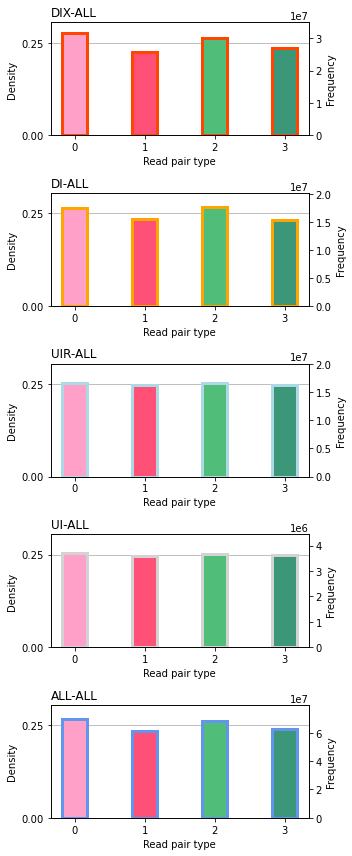

In [6]:
pdf_file_name = OUT_PREFIX + '_rpt.pdf'
e_cat = 'ALL'

RP_CAT_COLORS = [(255/255, 160/255, 200/255), (255/255, 80/255, 120/255), (80/255, 190/255, 120/255), (60/255, 150/255, 120/255)]
I_CAT_COLORS = {
    'DIX': 'orangered',
    'DI': 'orange',
    'UIR': 'lightblue',
    'UI': 'lightgray',
    'ALL': 'cornflowerblue'
}
rp_cat_labels = ['0', '1', '2', '3']

# Determine y_max
y_max_d = 0.25
for i_cat in ['DIX', 'DI', 'UIR', 'UI', 'ALL']:
    if y_max_d < max(RP_TYPE_DENS_DICT[i_cat][e_cat].values()):
        y_max_d = max(RP_TYPE_DENS_DICT[i_cat][e_cat].values())
y_max_d = y_max_d + y_max_d/10


x = np.arange(len(rp_cat_labels))  # the label locations
width = 0.35  # the width of the bars
density_tick_labels = np.arange(0, 1, 0.25)

fig, ax = plt.subplots(5, figsize=(5,12))

row_idx = 0
for i_cat in ['DIX', 'DI', 'UIR', 'UI', 'ALL']:
    
    # Create barchart
    ax[row_idx].bar(x, RP_TYPE_DENS_DICT[i_cat][e_cat].values(), width, color=RP_CAT_COLORS)
    ax[row_idx].set_title(i_cat + '-' + e_cat, loc='left')
    ax[row_idx].set_xticks(x)
    ax[row_idx].set_xticklabels(rp_cat_labels)
    ax[row_idx].axhline(0.25, zorder=0, color='gray', linewidth=0.5)
    ax[row_idx].set_xlabel('Read pair type')
    ax[row_idx].set_ylabel('Density')
    ax[row_idx].set_yticks(ticks=density_tick_labels)
    
    # Add second axis with absolute counts and normalize to maximum density
    ax2 = ax[row_idx].twinx()
    ax2.bar(x, RP_TYPE_FREQ_DICT[i_cat][e_cat].values(), width, color=RP_CAT_COLORS, edgecolor=I_CAT_COLORS[i_cat], linewidth=3)
    ax2.set_ylabel('Frequency')
    ax[row_idx].set_ylim(0, y_max_d)    
    y_lim = y_max_d*sum(RP_TYPE_FREQ_DICT[i_cat][e_cat].values())
    ax2.set_ylim(0, y_lim)
    #ax2.get_yaxis().set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax2.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))

    row_idx += 1

fig.tight_layout()
fig.savefig(pdf_file_name)

plt.show()

## Counting configurations of interactions

Count interactions separately for different configurations, interaction categories and enrichment states. See:

section ***Configurations of unbalanced interactions***

and ***Figure 3*** and ***Table 4*** in the manuscript.

In [7]:
# Initialize dictionary for counts
HT_TAG_FREQ_DICT = dict()
for i_cat in ['DIX', 'DI', 'UIR', 'UI', 'ALL']:
    HT_TAG_FREQ_DICT[i_cat] = dict()
    for e_cat in ['NN', 'EE', 'NE', 'EN', 'ALL']:
        HT_TAG_FREQ_DICT[i_cat][e_cat] = dict()
        for i_conf in ['0X', '1X', '2X', '3X', '01', '02', '03', '12', '13', '23']:
            HT_TAG_FREQ_DICT[i_cat][e_cat][i_conf] = 0

# Get absolute frequencies
for d11_inter in d11_interaction_set.interaction_list:
    i_cat = d11_inter.get_category()
    e_cat = d11_inter.enrichment_status_tag_pair
    ht_tag = d11_inter.get_ht_tag()
    HT_TAG_FREQ_DICT[i_cat][e_cat][ht_tag] += 1
    HT_TAG_FREQ_DICT['ALL'][e_cat][ht_tag] += 1
    HT_TAG_FREQ_DICT[i_cat]['ALL'][ht_tag] += 1
    HT_TAG_FREQ_DICT['ALL']['ALL'][ht_tag] += 1
    
# Fill second dictionary with realtive frequencies
HT_TAG_DENS_DICT = copy.deepcopy(HT_TAG_FREQ_DICT)
for i_cat in ['DIX','DI','UIR','UI','ALL']:
    for e_cat in ['NN','EE','NE','EN','ALL']:
        i_total = sum(HT_TAG_FREQ_DICT[i_cat][e_cat].values())
        if 0 < i_total:
            for ht_tag in ['0X','1X','2X','3X', '01','02','03','12','13','23']:
                HT_TAG_DENS_DICT[i_cat][e_cat][ht_tag] = HT_TAG_FREQ_DICT[i_cat][e_cat][ht_tag]/i_total
        else:
            for ht_tag in ['0X','1X','2X','3X', '01','02','03','12','13','23']:
                HT_TAG_DENS_DICT[i_cat][e_cat][ht_tag] = 0.0

Output all absolute frequencies and relative frequencies in a formatted way.

In [8]:
for i_cat in ['DIX', 'DI', 'UIR', 'UI', 'ALL']:
    print(i_cat)
    for e_cat in ['NN', 'EE', 'NE', 'EN', 'ALL']:
        print('\t\t' + e_cat, end='')
    print()
    for ht_tag in ['0X','1X','2X','3X', '01','02','03','12','13','23']:
        print('\t' + ht_tag + ': ', end='')
        for e_cat in ['NN', 'EE', 'NE', 'EN', 'ALL']:
            print('\t' + "{:,}".format(HT_TAG_FREQ_DICT[i_cat][e_cat][ht_tag]), end='')
            print(' (' + "{:.2f}".format(HT_TAG_DENS_DICT[i_cat][e_cat][ht_tag]) + ')', end='')
        print()

DIX
		NN		EE		NE		EN		ALL
	0X: 	303 (0.02)	494 (0.01)	7,076 (0.01)	7,513 (0.01)	15,386 (0.01)
	1X: 	215 (0.01)	252 (0.00)	5,603 (0.01)	5,175 (0.01)	11,245 (0.01)
	2X: 	121 (0.01)	347 (0.01)	7,332 (0.01)	8,061 (0.01)	15,861 (0.01)
	3X: 	450 (0.03)	422 (0.01)	5,295 (0.01)	4,914 (0.01)	11,081 (0.01)
	01: 	85 (0.01)	401 (0.01)	5,310 (0.01)	5,318 (0.01)	11,114 (0.01)
	02: 	1,977 (0.13)	15,910 (0.29)	75,322 (0.14)	241,384 (0.43)	334,593 (0.28)
	03: 	5,362 (0.36)	14,452 (0.26)	189,051 (0.34)	73,279 (0.13)	282,144 (0.24)
	12: 	1,704 (0.12)	11,634 (0.21)	192,986 (0.35)	65,103 (0.12)	271,427 (0.23)
	13: 	4,417 (0.30)	10,351 (0.19)	63,675 (0.11)	146,226 (0.26)	224,669 (0.19)
	23: 	67 (0.00)	736 (0.01)	4,466 (0.01)	4,126 (0.01)	9,395 (0.01)
DI
		NN		EE		NE		EN		ALL
	0X: 	13,767 (0.06)	3,590 (0.04)	63,452 (0.04)	70,030 (0.05)	150,839 (0.05)
	1X: 	10,200 (0.05)	2,968 (0.03)	65,307 (0.04)	57,893 (0.04)	136,368 (0.04)
	2X: 	9,389 (0.04)	3,728 (0.04)	72,844 (0.05)	73,731 (0.05)	159,692 (0.05)
	3X: 	13,

For Hi-C data, it makes no sense to distinguish between different enrichment states. Therefore, we implemented a  method that can be used to plot, for each interaction category, the frequencies of only one enrichment state and we we use the enrichment category `ALL` to create such plots for Hi-C. The sum of the 10 relative frequencies is 1 for each interaction category.

In [9]:
def get_ht_tag_bar_chart_one_e_cat(
    ht_tag_freq_dict = None,
    e_cat_1 = 'ALL',
    e_cat_1_color = 'darkred',
    i_cats = ['DIX','DI','UIR','UI','ALL'],
    pdf_file_name = 'ht_tag_barplot_for_two_e_cats.pdf'):
    """
    This function creates one bar chart for each interaction category.
    For each HT configuration tag there is one bar that represent the frequencies of the configurations
    in the enrichment category passed.
    """

    # Define labels and colors
    config_colors = ['grey','grey','grey','grey','pink','red','lime','magenta','blue','turquoise']
    i_cat_text = {'DIX': 'Unbalanced without reference',
                  'DI': 'Unbalanced',
                  'UIR': 'Balanced reference',
                  'UI': 'Unbalanced',
                  'ALL': 'All'}

    # Fill second dictionary with recalcultated realtive frequencies (required for second y-axis)
    ht_tag_dens_dict = copy.deepcopy(ht_tag_freq_dict)
    for i_cat in i_cats:
        i_total = sum(ht_tag_freq_dict[i_cat][e_cat_1].values())
        if 0 < i_total:
            for ht_tag in ['0X','1X','2X','3X', '01','02','03','12','13','23']:
                ht_tag_dens_dict[i_cat][e_cat_1][ht_tag] = ht_tag_freq_dict[i_cat][e_cat_1][ht_tag]/i_total
        else:
            for ht_tag in ['0X','1X','2X','3X', '01','02','03','12','13','23']:
                ht_tag_dens_dict[i_cat][e_cat_1][ht_tag] = 0.0

    # Determine maximal densities over all interactions categories
    y_max_d = 0.00
    for i_cat in i_cats:
        if y_max_d < max(ht_tag_dens_dict[i_cat][e_cat_1].values()):
            y_max_d = max(ht_tag_dens_dict[i_cat][e_cat_1].values())
    y_max_d = y_max_d + y_max_d/10


    # Create a figure with plots for all interaction categories
    fig, ax = plt.subplots(5, figsize=(5.1,12))

    x_labels = ['0X','1X','2X','3X', '01','02','03','12','13','23']
    x = np.arange(len(x_labels))  # the label locations
    width = 0.35*2  # the width of the bars

    row_idx = 0 # Row in the plot grid
    for i_cat in i_cats:

        # The recalcultated densities for the combined enrichment categories
        e1_dens = ht_tag_dens_dict[i_cat][e_cat_1].values()

        # The absolute frequencies that were passed to the function
        e1_freq = ht_tag_freq_dict[i_cat][e_cat_1].values()

        # Create bars for densities
        rects_e1 = ax[row_idx].bar(x, e1_dens, width, label=e_cat_1, color=config_colors, edgecolor=config_colors, linewidth=1.5)

        # Add some text for labels, title and custom x-tick labels, etc.
        ax[row_idx].set_xlabel('Configuration', fontsize=11.2)
        ax[row_idx].set_ylabel('Density', fontsize=11.2)
        ax[row_idx].set_title(i_cat_text[i_cat] + ' (' + i_cat + ')', loc='left')
        ax[row_idx].set_xticks(x)
        ax[row_idx].set_xticklabels(x_labels)
        e1_patch = mpatches.Patch(color=e_cat_1_color, label=e_cat_1)
        #ax[row_idx].legend(handles=[e1_patch], fontsize=8)

        # Add second axis with absolute frequencies
        ax2 = ax[row_idx].twinx()
        ax2.bar(x - 0.45*width, e1_freq, width, color='black', edgecolor='black', linewidth=3, alpha=0) # Set to alpha=1 to control scaling of y-axes
        ax2.bar(x + 0.45*width, e1_freq, width, color='black', edgecolor='black', linewidth=3, alpha=0)
        ax2.set_ylabel('Frequency', fontsize=12)

        # Scale second y-axis to maximum density
        ax[row_idx].set_ylim(0, y_max_d)    
        y_max_f = y_max_d*(sum(e1_freq))
        ax2.set_ylim(0, y_max_f)
        #ax2.get_yaxis().set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        ax2.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
        
        # Increse tick label sizes
        ax[row_idx].tick_params(axis='both', which='major', labelsize=11)
        ax2.tick_params(axis='both', which='major', labelsize=11)

        # Go to the next row of the plot grid
        row_idx += 1

    # Save and show plot
    fig.tight_layout()
    fig.savefig(pdf_file_name)
    plt.show()

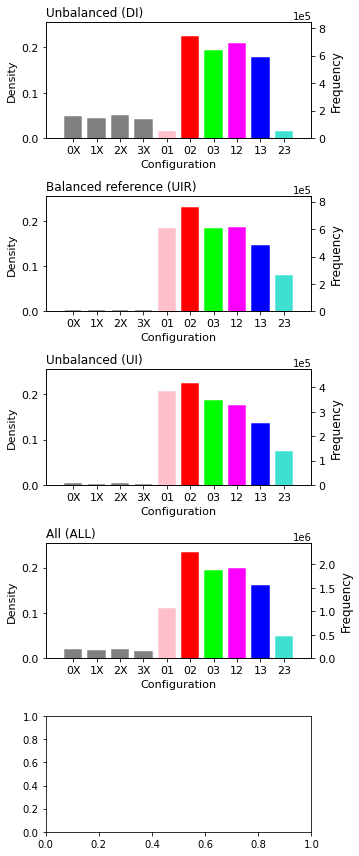

In [10]:
# Use this method for Hi-C datasets
get_ht_tag_bar_chart_one_e_cat(
    ht_tag_freq_dict = HT_TAG_FREQ_DICT,
    e_cat_1 = 'ALL',
    e_cat_1_color = 'beige',
    i_cats = ['DI', 'UIR', 'UI', 'ALL'],
    pdf_file_name = OUT_PREFIX + '_ALL_ALL_' + 'ht_tag_barplot_for_one_e_cat_ALL.pdf'
    )

For capture Hi-C data, we can distinguish interactions by enrichment status. For this purpose, we implemented a method that can be used to combine the frequencies of interactions from two enrichment states and the ten configurations into a grouped bar chart. The sum of the 20 relative frequencies (2 enrichment states and 10 configurations) is 1 for each interaction category. We used this method to compare the enrichment states `NE` and `EN`.

In [11]:
def get_ht_tag_bar_chart_for_two_e_cats(
    ht_tag_freq_dict = None,
    e_cat_1 = 'NE',
    e_cat_2 = 'EN',
    e_cat_1_color = 'darkred',
    e_cat_2_color = 'darkblue',
    i_cats = ['DIX','DI','UIR','UI','ALL'],
    pdf_file_name = 'ht_tag_barplot_for_two_e_cats.pdf'):
    """
    This function creates a grouped bar chart for each interaction category.
    For each HT configuration tag there are two bars that represent the frequencies of configurations
    in the two enrichment categories passed.
    The sum of the 20 relative frequencies (2 enrichment states and 10 configurations) is 1
    for each interaction category.
    """

    # Define colors and labels
    config_colors = ['grey','grey','grey','grey','pink','red','lime','magenta','blue','turquoise']
    i_cat_text = {'DIX': 'Unbalanced without reference',
                  'DI': 'Unbalanced',
                  'UIR': 'Balanced reference',
                  'UI': 'Unbalanced',
                  'ALL': 'All'}

    # Fill second dictionary with recalcultated realtive frequencies for e_cat_1 (NE) and e_cat_2 (EN) combined (required for second y-axis)
    ht_tag_dens_dict = copy.deepcopy(ht_tag_freq_dict)
    for i_cat in i_cats:
        i_total = sum(ht_tag_freq_dict[i_cat][e_cat_1].values()) + sum(ht_tag_freq_dict[i_cat][e_cat_2].values())
        if 0 < i_total:
            for ht_tag in ['0X','1X','2X','3X', '01','02','03','12','13','23']:
                ht_tag_dens_dict[i_cat][e_cat_1][ht_tag] = ht_tag_freq_dict[i_cat][e_cat_1][ht_tag]/i_total
                ht_tag_dens_dict[i_cat][e_cat_2][ht_tag] = ht_tag_freq_dict[i_cat][e_cat_2][ht_tag]/i_total
        else:
            for ht_tag in ['0X','1X','2X','3X', '01','02','03','12','13','23']:
                ht_tag_dens_dict[i_cat][e_cat_1][ht_tag] = 0.0
                ht_tag_dens_dict[i_cat][e_cat_2][ht_tag] = 0.0

    # Determine maximal densities over all interactions categories and e_cat_1 (NE) and e_cat_2 (EN)
    y_max_d = 0.00
    for i_cat in i_cats:
        for e_cat in [e_cat_1, e_cat_2]:
            if y_max_d < max(ht_tag_dens_dict[i_cat][e_cat].values()):
                y_max_d = max(ht_tag_dens_dict[i_cat][e_cat].values())
    y_max_d = y_max_d + y_max_d/10


    # Create a figure with plots for all interaction categories
    fig, ax = plt.subplots(5, figsize=(5.1,12))

    x_labels = ['0X','1X','2X','3X','01','02','03','12','13','23']
    x = np.arange(len(x_labels))  # the label locations
    width = 0.35  # the width of the bars

    row_idx = 0 # Row in the plot grid
    for i_cat in i_cats:

        # The recalcultated densities for the two combined enrichment categories
        e1_dens = ht_tag_dens_dict[i_cat][e_cat_1].values()
        e2_dens = ht_tag_dens_dict[i_cat][e_cat_2].values()

        # The absolute frequencies that were passed to the function
        e1_freq = ht_tag_freq_dict[i_cat][e_cat_1].values()
        e2_freq = ht_tag_freq_dict[i_cat][e_cat_2].values()

        # Create bars for densities
        rects_e1 = ax[row_idx].bar(x - 0.5*width, e1_dens, width, label=e_cat_1, color=e_cat_1_color, edgecolor=e_cat_1_color, linewidth=1.5)
        rects_e2 = ax[row_idx].bar(x + 0.5*width, e2_dens, width, label=e_cat_2, color=e_cat_2_color, edgecolor=e_cat_2_color, linewidth=1.5)

        # Add some text for labels, title and custom x-tick labels, etc.
        ax[row_idx].set_xlabel('Configuration', fontsize=11.2)
        ax[row_idx].set_ylabel('Density', fontsize=11.2)
        ax[row_idx].set_title(i_cat_text[i_cat] + ' (' + i_cat + ')', loc='left')
        ax[row_idx].set_xticks(x)
        ax[row_idx].set_xticklabels(x_labels)
        e1_patch = mpatches.Patch(color=e_cat_1_color, label=e_cat_1)
        e2_patch = mpatches.Patch(color=e_cat_2_color, label=e_cat_2)
        ax[row_idx].legend(handles=[e1_patch, e2_patch], fontsize=9.5, loc='upper left')

        # Add second axis with absolute frequencies
        ax2 = ax[row_idx].twinx()
        ax2.bar(x - 0.9*width, e1_freq, width, color='red', edgecolor='red', linewidth=1.5, alpha=0) # Set to alpha=1 to control scaling of y-axes
        ax2.bar(x + 0.9*width, e2_freq, width, color='red', edgecolor='red', linewidth=1.5, alpha=0)
        ax2.set_ylabel('Frequency', fontsize=12)

        # Scale second y-axis to maximum density
        ax[row_idx].set_ylim(0, y_max_d)    
        y_max_f = y_max_d*(sum(e1_freq) + sum(e2_freq)) # This is possible, because we are using the combined densities of NE and EN
        ax2.set_ylim(0, y_max_f)
        #ax2.get_yaxis().set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        ax2.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
        
        # Increse tick label sizes
        ax[row_idx].tick_params(axis='both', which='major', labelsize=11)
        ax2.tick_params(axis='both', which='major', labelsize=11)

        # Go to the next row of the plot grid
        row_idx += 1

    # Save and show plot
    fig.tight_layout()
    fig.savefig(pdf_file_name)
    plt.show()

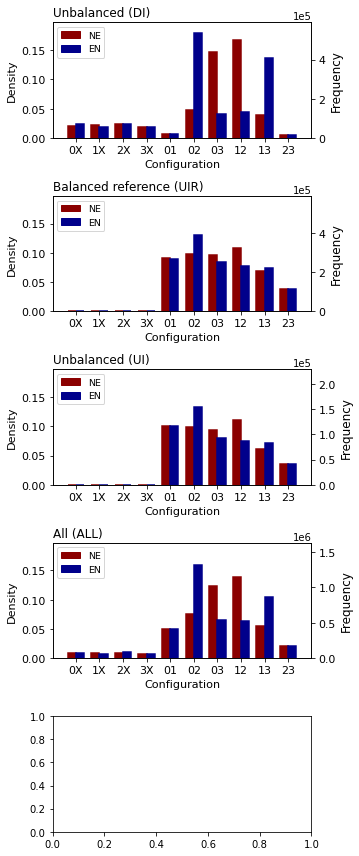

In [12]:
# Use this for CHC data
get_ht_tag_bar_chart_for_two_e_cats(
    ht_tag_freq_dict = HT_TAG_FREQ_DICT,
    e_cat_1 = 'NE',
    e_cat_2 = 'EN',
    e_cat_1_color = 'darkred',
    e_cat_2_color = 'darkblue',
    i_cats = ['DI', 'UIR', 'UI', 'ALL'],
    pdf_file_name = OUT_PREFIX + '_NE_EN_' + 'ht_tag_barplot_for_two_e_cats.pdf'
    )